In [70]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet


In [71]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(15),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [72]:
# Paths to dataset folders
train_dir = "data/train"
test_dir = "data/test"

# Datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_val)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Debugging Outputs
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")
print(f"Train Loader Size: {len(train_loader)}")
print(f"Test Loader Size: {len(test_loader)}")



Train Dataset Size: 5144
Test Dataset Size: 1288
Train Loader Size: 161
Test Loader Size: 41


In [77]:
# Load pretrained EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the final layer for 3 classes (NORMAL, PNEUMONIA, COVID)
num_classes = 3
model._fc = nn.Linear(model._fc.in_features, num_classes)

# Send model to device (GPU/CPU)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
model = model.to(device)

# Debugging Outputs
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"MPS Available: {torch.backends.mps.is_available()}")
print(f"Using device: {device}")


Loaded pretrained weights for efficientnet-b0
CUDA Available: False
MPS Available: True
Using device: mps


In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [79]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [80]:
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels).item()
        total_train += labels.size(0)

    train_accuracy = 100.0 * train_correct / total_train
    train_losses.append(train_loss / len(train_loader))  # Append training loss
    train_accuracies.append(train_accuracy)  # Append training accuracy

    print(
        f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels).item()
            total_val += labels.size(0)

    val_accuracy = 100.0 * val_correct / total_val
    val_losses.append(val_loss / len(test_loader))  # Append validation loss
    val_accuracies.append(val_accuracy)  # Append validation accuracy

    print(f"Validation Loss: {val_loss / len(test_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")


KeyboardInterrupt: 

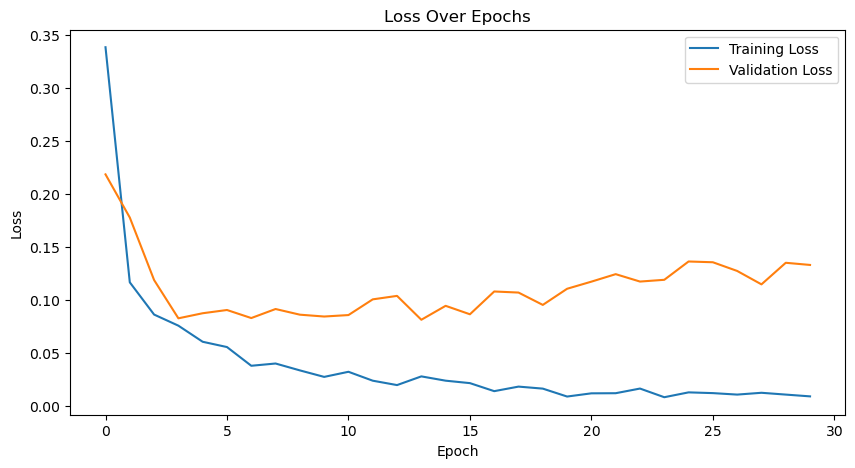

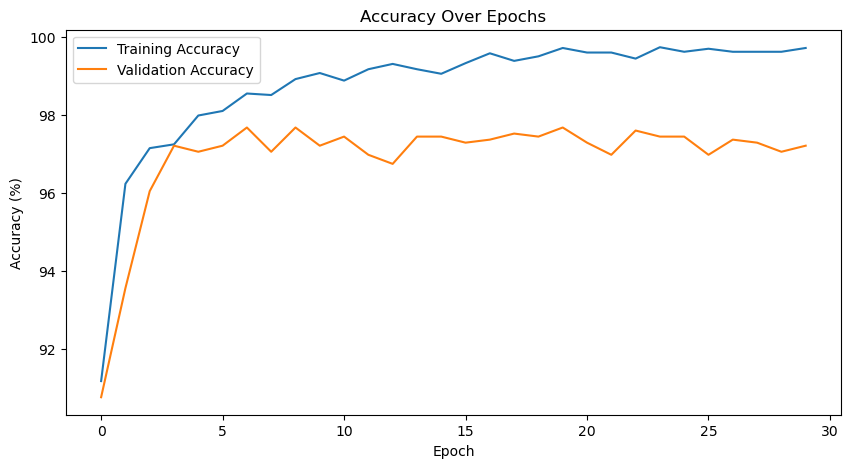

In [47]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [48]:
torch.save(model.state_dict(), 'efficientnet_chest_xray_b7.pth')

In [49]:
model.load_state_dict(torch.load('efficientnet_chest_xray_b7.pth', weights_only=True))

<All keys matched successfully>

In [50]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')


Accuracy: 97.20%


#### Predicting on a single image

In [51]:
from PIL import Image
import torch
import torchvision.transforms as transforms

# Load class names dynamically
train_dataset = datasets.ImageFolder(root='data/train')
class_names = train_dataset.classes  # Dynamically load class names

# Updated transform
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels for grayscale images
    transforms.Resize((224, 224)),  # Resize to EfficientNet input size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize for ImageNet weights
                         std=[0.229, 0.224, 0.225]),
])

# Load and preprocess image
# img = Image.open('data/test/COVID19/COVID19(464).jpg')
# img = Image.open('data/test/NORMAL/NORMAL(1266).jpg')
img = Image.open('data/test/PNEUMONIA/PNEUMONIA(3418).jpg')
img = transform(img).unsqueeze(0)  # Add batch dimension

# Set the model to evaluation mode
model.eval()

# Predict
with torch.no_grad():
    img = img.to(device)
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)
    predicted_class = class_names[predicted.item()]  # Get class name
    print(f'Predicted Class: {predicted_class}')


Predicted Class: PNEUMONIA


#### Train images:
- COVID19: 460 images
- NORMAL: 1266 images
- PNEUMONIA: 3418 images

#### Test images:
- COVID19: 116 images
- NORMAL: 317 images
- PNEUMONIA: 855 images


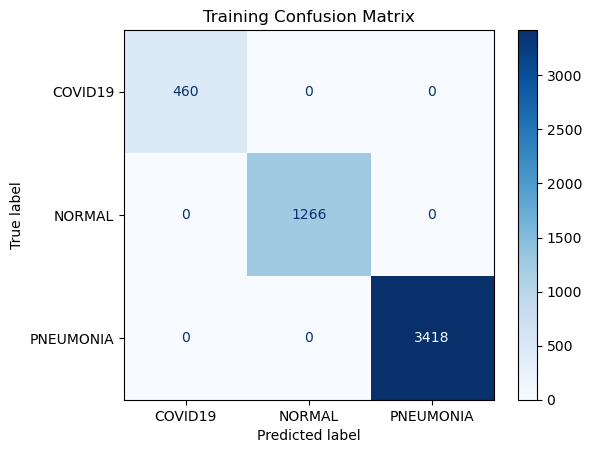

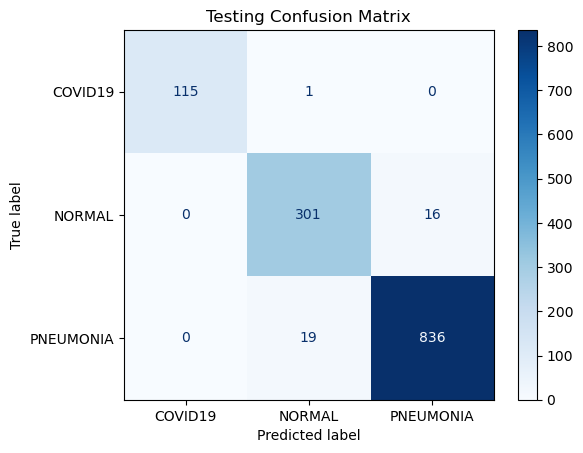

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


# Function to compute confusion matrix for a given DataLoader
def compute_confusion_matrix(loader, model, device):
    all_preds = []
    all_labels = []

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Collect all predictions
            all_labels.extend(labels.cpu().numpy())  # Collect all true labels

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return cm


# Compute confusion matrices
train_cm = compute_confusion_matrix(train_loader, model, device)
test_cm = compute_confusion_matrix(test_loader, model, device)

# Plot Training Confusion Matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=class_names)
disp_train.plot(cmap=plt.cm.Blues)
plt.title('Training Confusion Matrix')
plt.show()

# Plot Testing Confusion Matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=class_names)
disp_test.plot(cmap=plt.cm.Blues)
plt.title('Testing Confusion Matrix')
plt.show()


In [67]:
from sklearn.metrics import precision_recall_fscore_support

# Collect predictions and true labels
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate metrics
precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)
class_names = train_dataset.classes

# Print metrics per class
for i, cls in enumerate(class_names):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1 Score: {f1[i]:.2f}")
    print(f"  Support: {support[i]}")

# Overall metrics
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
print(f"Macro F1 Score: {f1_macro:.2f}")

precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1_weighted:.2f}")


Class: COVID19
  Precision: 1.00
  Recall: 0.99
  F1 Score: 1.00
  Support: 116
Class: NORMAL
  Precision: 0.94
  Recall: 0.95
  F1 Score: 0.94
  Support: 317
Class: PNEUMONIA
  Precision: 0.98
  Recall: 0.98
  F1 Score: 0.98
  Support: 855
Macro F1 Score: 0.97
Weighted F1 Score: 0.97
